## Chapter 17 exercises.

*  I am going to focus on the Voices exercises rather then the sleep one. 



In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import seaborn as sns
import xarray as xr

In [2]:
voices = pd.read_csv("voices.csv")
voices = voices[['subject','attitude','pitch']]
voices.dropna(inplace=True)
voices.tail()

,subject,attitude,pitch
79,F,informal,156.5
80,F,polite,146.7
81,F,informal,158.0
82,F,informal,161.1
83,F,polite,153.3


In [32]:
voices['pitch'].std()

65.5406802449465

In [49]:
voices.groupby('subject').std().mean()

pitch    29.165363
dtype: float64

In [44]:
voices.groupby('subject').mean().std()

pitch    63.471421
dtype: float64

## Exercise 17.10

### Part a

This will use a random intercepts model (assuming impact of attitude on pitch is similar amoung all subjects). Subjects are our grouping variable  

$$
Y_{ij}|b_{0j},\beta_1,\sigma_y \sim N(\mu_{ij}, \sigma_y^2) \text{  with  } \mu_{ij} = (b_{0j} + \beta_0)+ \beta_1 X_{ij}\\
b_{0j} |  \sigma_0 \sim N(0, \sigma_0^2)\\
\beta_0 \sim N()\\
\beta_1 \sim N()\\
\sigma_y \sim Exp()\\
\sigma_0 \sim Exp()
$$

The prior distributions will use weakly informative priors from bambi except for pitch sigma where i have to force an exponential

In [3]:
sig0_prior = bmb.priors.Prior("Exponential",lam=1/65.0 ) # between group variation was about 65
sigy_prior = bmb.priors.Prior("Exponential",lam=1/65.0 )  # withing group variation was smaller, but I will use the larger value
group_prior = bmb.priors.Prior("Normal", mu = 0, sigma= sigy_prior)

model1 = bmb.Model('pitch ~ attitude + (1 | subject)', priors = {'1|subject': group_prior, 'sigma' : sig0_prior},data= voices)
model1.build()
model1

Formula: pitch ~ attitude + (1 | subject)
Family name: Gaussian
Link: identity
Observations: 83
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 193.5819, sigma: 228.9461)
    attitude ~ Normal(mu: 0.0, sigma: 325.7469)

  Group-level effects
    1|subject ~ Normal(mu: 0, sigma: Exponential(lam: 0.0154))

  Auxiliary parameters
    sigma ~ Exponential(lam: 0.0154)

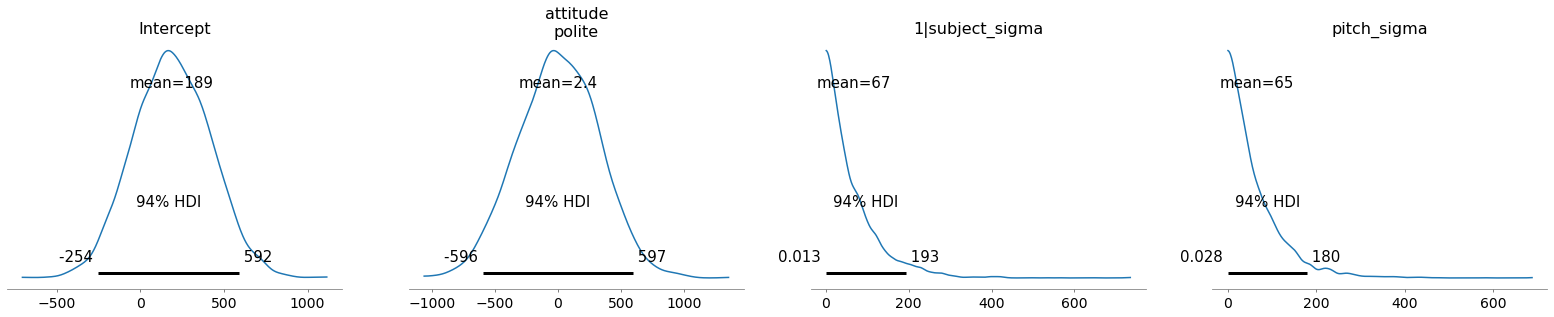

In [4]:
model1.plot_priors();

### Part b
Ok with the priors out of the way, lets consider the rest of this exercise.  Above we see that bambi chose 'informal' as baseline.
THe meaning of $\beta_{0j}$ is the group level intercept, meaning it is the individual subjects base line, informal speech pitch.  $\beta_0$ is the baseline informal pitch on average without considering which subject it is.  So $\beta_{0j} = \beta_0 + b_{1j}$ where $b_{1j}$ is the offset from baseline for each subject, which is what pymc will actually (above called `1|subject`)


$\beta_1$ is perhaps the most important parameter, which tells us how much pitch is shifted for 'polite' vs 'informal'  dialogue. (Note bambi used 'informal' as baseline)

### Part c
$\sigma_y$ is the (common) variation within subject of pitch with all else held equal. $\sigma_0$ is teh variation between subjects of the baseline pitch. 


## Exercise 17.11

In [50]:
voices.groupby('subject').count()

,attitude,pitch
subject,,
A,14,14
B,13,13
C,14,14
D,14,14
E,14,14
F,14,14


There were six subjects, each of them did 14 dialogs except subject B which we had to drop one dialog due to NA data

In [52]:
voices.groupby(['subject','attitude']).count()

pitch
subject attitude       
A       informal      7
        polite        7
B       informal      7
        polite        6
C       informal      7
        polite        7
D       informal      7
        polite        7
E       informal      7
        polite        7
F       informal      7
        polite        7

Looks like the data is pretty evenly divided, again except for missing data for subject b

<AxesSubplot:xlabel='subject', ylabel='pitch'>

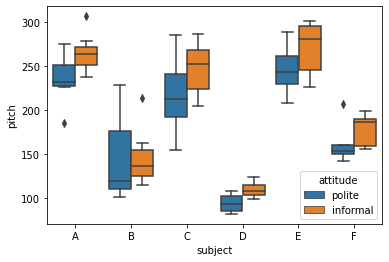

In [56]:
sns.boxplot(data = voices, y='pitch', x='subject', hue = 'attitude')

This shows that it seems that generally informal speech has a higher pitch for each subject, and as required by our model, the increase in pitch is about the same for each case. 

<AxesSubplot:xlabel='pitch', ylabel='Density'>

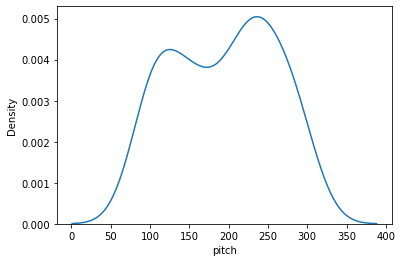

In [82]:
sns.kdeplot(voices['pitch'])

## Exercise 17.12

### Part a

In [4]:
results = model1.fit(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, attitude, 1|subject_sigma, 1|subject_offset, pitch_sigma]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.


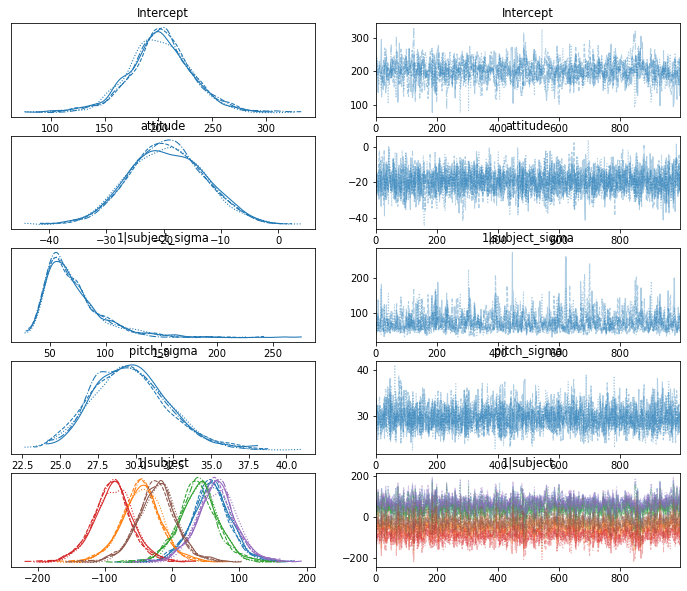

In [68]:
az.plot_trace(results, compact=True);

In [69]:
az.summary(results,hdi_prob = 0.95 )

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,201.813,29.964,138.002,259.944,0.952,0.678,992.0,1374.0,1.0
attitude[polite],-19.414,6.621,-31.952,-6.382,0.138,0.101,2308.0,1952.0,1.0
1|subject_sigma,71.472,26.401,33.709,123.085,0.794,0.562,1056.0,1872.0,1.0
pitch_sigma,29.672,2.501,24.664,34.414,0.052,0.038,2378.0,2155.0,1.0
1|subject[A],57.718,30.434,-7.420,114.458,0.957,0.677,1017.0,1494.0,1.0
1|subject[B],-45.978,30.640,-107.560,16.322,0.959,0.678,1026.0,1530.0,1.0
1|subject[C],39.267,30.478,-21.261,99.719,0.955,0.676,1017.0,1487.0,1.0
1|subject[D],-88.534,30.602,-152.635,-28.143,0.954,0.678,1034.0,1499.0,1.0
1|subject[E],65.335,30.568,1.231,123.283,0.954,0.675,1033.0,1460.0,1.0
1|subject[F],-22.820,30.449,-89.169,34.168,0.952,0.700,1032.0,1405.0,1.0


<AxesSubplot:xlabel='pitch / pitch'>

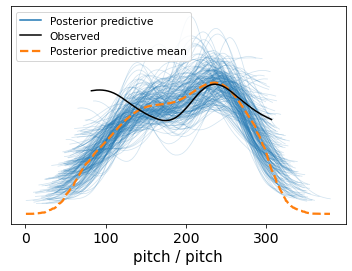

In [72]:
model1.predict(results, kind='pps')
az.plot_ppc(results, data_pairs = {'pitch' : 'pitch'},num_pp_samples=200)

The ppc shows we capture the range of values, but not quite the shape.  Not sure what can be done about that!  Quick check using default priors "model2"

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, attitude, 1|subject_sigma, 1|subject_offset, pitch_sigma]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Incr

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,203.733,33.827,141.025,271.751,1.394,1.035,604.0,693.0,1.01
attitude[polite],-19.385,6.763,-31.986,-6.870,0.134,0.095,2542.0,2033.0,1.00
1|subject_sigma,80.706,30.899,37.009,138.605,1.148,0.824,731.0,900.0,1.00
pitch_sigma,29.623,2.417,25.300,34.126,0.050,0.036,2348.0,2179.0,1.00
1|subject[A],55.771,34.158,-9.402,121.862,1.361,0.963,646.0,657.0,1.01
1|subject[B],-48.148,34.354,-115.163,16.306,1.439,1.107,579.0,999.0,1.01
1|subject[C],37.288,34.298,-27.941,103.554,1.395,0.987,619.0,746.0,1.01
1|subject[D],-90.574,34.400,-161.021,-28.346,1.426,1.110,601.0,732.0,1.01
1|subject[E],63.229,34.047,0.370,132.378,1.398,0.989,605.0,903.0,1.01
1|subject[F],-24.811,34.331,-92.519,40.430,1.385,1.086,635.0,833.0,1.01


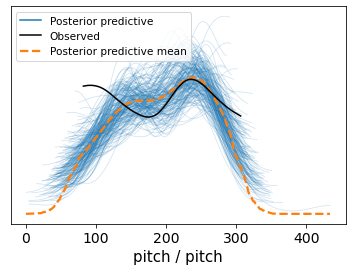

In [73]:

model2 = bmb.Model('pitch ~ attitude + (1 | subject)',data= voices)
results2= model2.fit()
model2.predict(results2, kind='pps')
az.plot_ppc(results2,num_pp_samples=200)
az.summary(results2)

No real difference, pressign on with model1

### Part b

We constructed the intervals above, see the table. $\beta_0$, the global average pitch for 'imformal' conversation, is on average from 140 Hz to 260 Hz (95% HDI). 

### Part c and d
For $\beta_1$  we see that 95% HDI does not include 0 and ranges from -32 to -7 Hz.  That is, for this data, people tend to lower their pitch in polite conversation in this range.   This range does not include zero, and there seems to be ample evidence that people do lower their pitch like this. For fun, lets plot the posterior for $\beta_1$.



In [5]:
post_df = results.posterior.to_dataframe().reset_index().drop(columns = ['chain','draw'])
post_df.head()

,attitude_dim,subject__factor_dim,Intercept,attitude,1|subject_sigma,pitch_sigma,1|subject
0,polite,A,163.781408,-23.712625,74.977306,28.10683,84.243542
1,polite,B,163.781408,-23.712625,74.977306,28.10683,7.318534
2,polite,C,163.781408,-23.712625,74.977306,28.10683,79.247258
3,polite,D,163.781408,-23.712625,74.977306,28.10683,-41.496671
4,polite,E,163.781408,-23.712625,74.977306,28.10683,111.912762


<AxesSubplot:xlabel='attitude', ylabel='Density'>

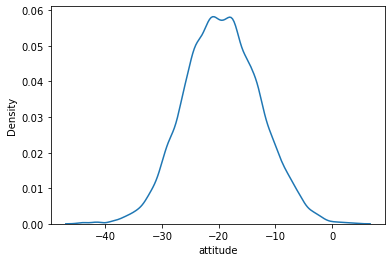

In [81]:
sns.kdeplot(post_df.attitude)

## Exercise 17.13

### Part a).   
The global posterior median model is simply that the median pitch is normally distributed follows this model:

$$
\mu =  \beta_0+ \beta_1 \text{   (if polite speech)}\\
\mu = \beta_0 \text{  (informal speech.)}\\
\\
\sigma = \sigma_0
$$

The two parameters have the ranges discussed.

### Part b). 

For subject level median models for A and F, from the summary we see that A's baseline pitch was 58 +-	30	 Hz higher (mean/std of posterior) and F's was lower by about -22 +- 30  Hz (mean +- std of posterior) . 

### Part c).

In [57]:
post_pred = model1.predict(results, kind='pps', data = pd.DataFrame({'subject' : ['A','F'], 'attitude' :['polite', 'polite']}),include_group_specific=True,inplace=False)

In [58]:
post_df = post_pred.posterior_predictive.to_dataframe().reset_index().drop(columns = ['chain','draw'])
# I presume that '0' is 'A','polite', not clear in docs.
post_df.groupby('pitch_dim_0').mean()


,pitch
pitch_dim_0,
0,240.441974
1,159.526531


In [45]:
post_df.head()

,pitch_dim_0,pitch
0,0,216.716921
1,1,194.812801
2,0,249.156877
3,1,178.320093
4,0,220.185427


<AxesSubplot:xlabel='pitch', ylabel='Density'>

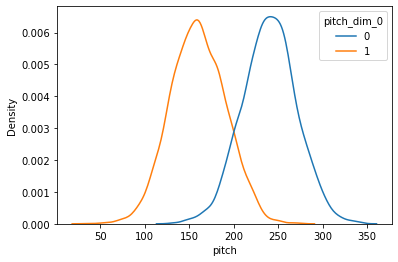

In [46]:
sns.kdeplot(data = post_df, x= 'pitch', hue = 'pitch_dim_0')

I need to add 'you' to this.  

### NOTE: THIS IS WRONG, see below

In [15]:
post_pred_you = model1.predict(results, kind='pps', data = pd.DataFrame({'subject' : ['A'], 'attitude' :['polite']}),include_group_specific=False,inplace=False)
post_you_df = post_pred_you.posterior_predictive.to_dataframe().reset_index().drop(columns = ['chain','draw'])
post_you_df.pitch_dim_0 = 2
post_you_df.head()

,pitch_dim_0,pitch
0,2,104.817647
1,2,209.658091
2,2,155.371242
3,2,186.230311
4,2,132.760911


In [49]:
def remap(value):
    if(value==0):
        return 'A'
    if(value == 1):
        return 'F'
    if(value == 2):
        return 'You'

In [112]:
full_df = pd.concat([post_df,post_you_df]).reset_index(drop=True)
full_df['subject'] = full_df.pitch_dim_0.apply(remap)

In [113]:
full_df.head()

,pitch_dim_0,pitch,subject
0,0,266.380283,A
1,1,164.134372,F
2,0,266.751638,A
3,1,108.903770,F
4,0,267.759455,A


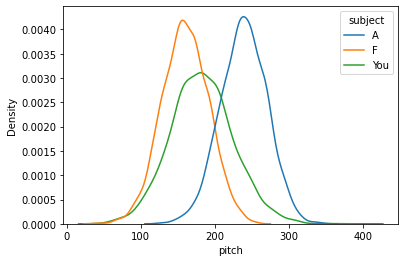

In [115]:
sns.kdeplot(data = full_df, x= 'pitch', hue = 'subject');

Note that for 'You', the uncertainty of polite speach frequency is wider since we have no data on the baseline speech. So we have to include the uncertainty in the group level intercept.  

 Walking though the process is kind of interesting. First we have to take a sample from our posterior for the baseline frequency ($\beta_0) as well as a sample for $\sigma_y$ and $\sigma_0$.  Using $\sigma_0$ we generate a random $b_1$ which is a sample of a possible group level baseline shift. Now we are talkign about polite conversation, and so we also need a draw from $\beta_1$ to shift the frequency for polite conversation. Finally we add the random effect using $\sigma_y$. 

 The A and F cases on the other hand take a direct sample of $\beta_1$ and so we dont have the effect of $\sigma_0$ (between group variance) and so they are narrower. 

 *NOTE* THIS PLOT IS WRONG, SEE BELOW

### CHeck posterior predictive for 'you'

In [59]:
posterior_df = results.posterior.to_dataframe().reset_index().drop(columns = ['chain'])
posterior_df.head()
 

,draw,attitude_dim,subject__factor_dim,Intercept,attitude,1|subject_sigma,pitch_sigma,1|subject
0,0,polite,A,181.200883,-21.436183,49.454761,25.266784,80.547513
1,0,polite,B,181.200883,-21.436183,49.454761,25.266784,-25.715113
2,0,polite,C,181.200883,-21.436183,49.454761,25.266784,65.598512
3,0,polite,D,181.200883,-21.436183,49.454761,25.266784,-65.676205
4,0,polite,E,181.200883,-21.436183,49.454761,25.266784,89.122627


Ok for a new group, we ingore the subject, which means we also ignore the '1|subject' but we do not ignore '1|subject_sigma'. 
Note we dont need all five for every draw because the between group effects are the same for each of these of course. So lets just take the 'A's 

In [60]:
post_df_new_group = posterior_df[posterior_df['subject__factor_dim']=='A'].drop(columns = ['subject__factor_dim', '1|subject']).reset_index(drop=True)
post_df_new_group.head()

,draw,attitude_dim,Intercept,attitude,1|subject_sigma,pitch_sigma
0,0,polite,181.200883,-21.436183,49.454761,25.266784
1,1,polite,179.759861,-22.481844,52.562871,25.630781
2,2,polite,186.833206,-18.183596,53.017082,25.494243
3,3,polite,186.069808,-15.801293,48.918553,24.142582
4,4,polite,193.419286,-16.837045,48.317412,26.656838


Now we only want the polite case. And then we use the parameters to compute predicted pitch

In [14]:
polite_samples = post_df_new_group[post_df_new_group['attitude_dim']=='polite'].reset_index(drop=True)
polite_samples['pitch'] = polite_samples['Intercept'] + polite_samples['attitude'] + \
       np.random.normal(scale = polite_samples['1|subject_sigma']) + np.random.normal(scale = polite_samples['pitch_sigma'])

In [26]:
polite_samples['source'] = "manual"

In [33]:
post_you_df['source'] = 'model.predict'
compare_df0 = post_you_df.drop(columns = 'pitch_dim_0')
compare_df0.head()

,pitch,source
0,104.817647,model.predict
1,209.658091,model.predict
2,155.371242,model.predict
3,186.230311,model.predict
4,132.760911,model.predict


In [34]:
manual_samples = polite_samples[['pitch', 'source']]

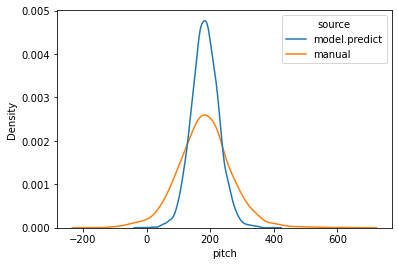

In [38]:
compare_df = pd.concat([compare_df0, manual_samples]).reset_index()
sns.kdeplot(data = compare_df, x= 'pitch', hue = 'source');


Well Shiza, it turns out that model.predict is NOT doing the between group variance after all. Lets try to see what it is doing

In [39]:
polite_samples.head()

,draw,attitude_dim,Intercept,attitude,1|subject_sigma,pitch_sigma,pitch,source
0,0,polite,181.200883,-21.436183,49.454761,25.266784,153.813692,manual
1,1,polite,179.759861,-22.481844,52.562871,25.630781,126.192018,manual
2,2,polite,186.833206,-18.183596,53.017082,25.494243,160.906298,manual
3,3,polite,186.069808,-15.801293,48.918553,24.142582,180.836017,manual
4,4,polite,193.419286,-16.837045,48.317412,26.656838,179.456135,manual


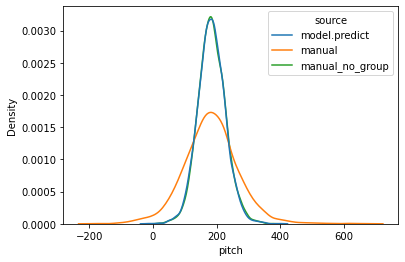

In [40]:
polite_samples_no_group = polite_samples.copy()
polite_samples_no_group['source'] = 'manual_no_group'
polite_samples_no_group['pitch'] = polite_samples['Intercept'] + polite_samples['attitude'] + \
         np.random.normal(scale = polite_samples['pitch_sigma'])
manual_samples_no_group = polite_samples_no_group[['pitch', 'source']]
compare_df2 = pd.concat([compare_df, manual_samples_no_group]).reset_index()
sns.kdeplot(data = compare_df2, x= 'pitch', hue = 'source');

Yes as I expected, `include_group_level = False` does not include between group effects and really does just what it says on the tin.  This means that answers I gave in chapter 16 were incorrectly described (although in that case the between group effects were small)

In [47]:
post_df.head()

,pitch_dim_0,pitch
0,0,216.716921
1,1,194.812801
2,0,249.156877
3,1,178.320093
4,0,220.185427


In [61]:
post_df['subject'] = post_df.pitch_dim_0.apply(remap)
post_df.drop(columns = 'pitch_dim_0', inplace = True)
post_df.head()

,pitch,subject
0,188.985254,A
1,195.658344,F
2,297.801690,A
3,123.298727,F
4,208.539806,A


In [70]:
polite_samples['subject']="You"


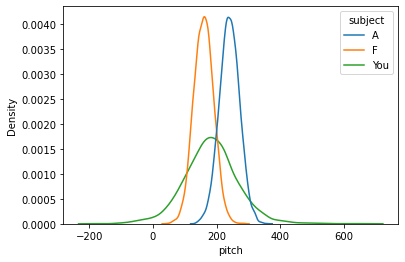

In [71]:
compare_df3 = pd.concat([post_df, polite_samples[['pitch','subject']]]).reset_index()
sns.kdeplot(data = compare_df3, x= 'pitch', hue = 'subject');

Much wider and it makes sense as it covers more area.
I think there is probably no way to do this automatically with bmb.model.predict.

## Look breifly at intercept and group intercept correlatino

In [11]:
posterior_df = results.posterior.to_dataframe().reset_index().drop(columns = ['chain'])
posterior_df.head()
post_df_gA = posterior_df[(posterior_df['subject__factor_dim']=='A') & (posterior_df['attitude_dim']=='polite')].drop(columns = ['subject__factor_dim']).reset_index(drop=True)
post_df_gA.head()

,draw,attitude_dim,Intercept,attitude,1|subject_sigma,pitch_sigma,1|subject
0,0,polite,163.781408,-23.712625,74.977306,28.106830,84.243542
1,1,polite,171.537917,-21.697619,71.583909,29.512176,95.636445
2,2,polite,197.662769,-19.707974,87.497271,27.477243,61.460145
3,3,polite,171.816890,-16.710111,89.893166,30.143560,87.092818
4,4,polite,168.768031,-16.166668,98.136563,30.052193,89.905174


<AxesSubplot:xlabel='Intercept', ylabel='1|subject'>

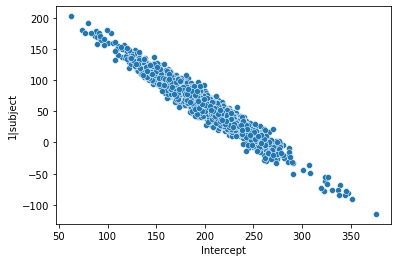

In [12]:
sns.scatterplot(data= post_df_gA, x = 'Intercept', y= '1|subject')

Ok this explains why the 'ignore_group_level' is wider even though it is not as wide as it should be